In [1]:
!pip -q install -U datasets diffusers accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is in

In [2]:
!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import partial
from torchvision import transforms
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler
import os
from torch.optim import AdamW
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
from accelerate import notebook_launcher


/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 2e-5
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"
    output_dir = "ddpm-butterfly"
    seed = 1211
    push_to_hub = False
    hub_model_id = None
    hub_private_repo = False
    overwrite_output_dir = True


config = TrainingConfig()

In [5]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

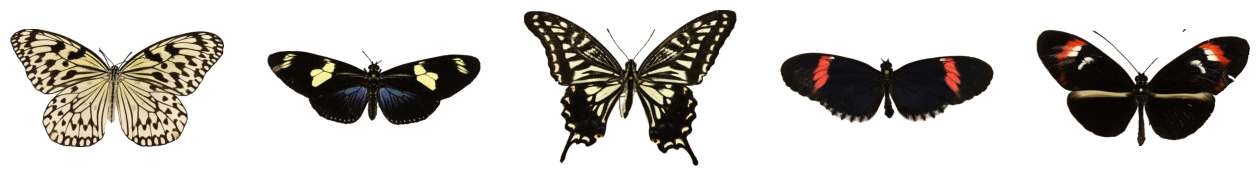

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:5]['image']):
    ax[i].imshow(image)
    ax[i].set_axis_off()
fig.show()

In [7]:
train_preprocess = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
def transform(examples, preprocess):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images': images}

train_dataset = dataset['train']

train_dataset.set_transform(partial(transform, preprocess=train_preprocess))

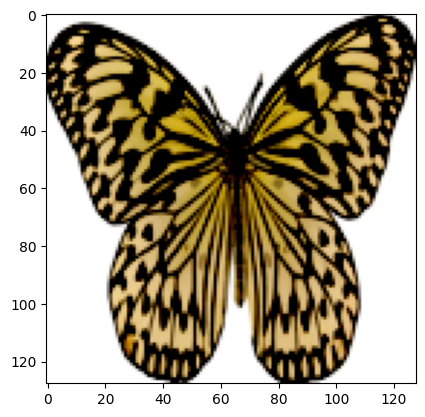

In [9]:
plt.imshow(train_dataset[0]['images'].permute(1, 2, 0))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)

In [11]:
# define DDPM model

model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)

paras = sum(p.numel() for p in model.parameters())
print("All parameters:", paras)

model

All parameters: 71436803


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [12]:
sample_image = train_dataset[0]['images'].unsqueeze(0)
sample_image.size()

torch.Size([1, 3, 128, 128])

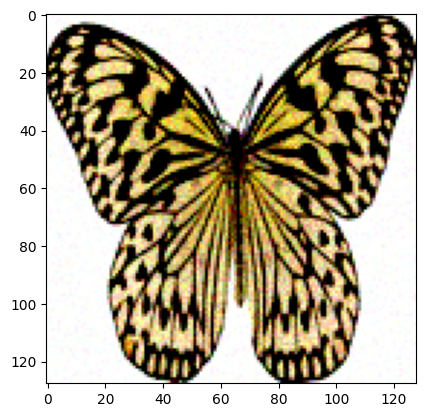

In [13]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.rand(sample_image.shape)

timesteps = torch.LongTensor([100])

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

plt.imshow((noisy_image.permute(0, 2, 3, 1))[0])

In [14]:
noise_pred = model(noisy_image, timesteps).sample

loss = torch.nn.functional.mse_loss(noise_pred, noise)

optimizer = AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=len(train_loader) * config.num_epochs
)

In [15]:
def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed)
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


In [18]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with='tensorboard',
        project_dir=os.path.join(config.output_dir, 'logs')
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name,
                exist_ok=True
            ).repo_id
        accelerator.init_trackers('train_example')

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f'Epoch {epoch}')

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64,
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = torch.nn.functional.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'steps': global_step
            }

            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)


            if (epoch + 1) % 10 == 0:
                images = pipeline(
                    batch_size=config.eval_batch_size,
                    generator=torch.manual_seed(config.seed)
                ).images

                image_grid = make_image_grid(images, rows=4, cols=4)
                plt.figure(figsize=(8, 8))
                plt.imshow(image_grid)
                plt.axis('off')
                plt.show()


            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*']
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [19]:
args = (config, model, noise_scheduler, optimizer, train_loader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
ddpm_pipeline = DDPMPipeline.from_pretrained(config.output_dir).to('cuda')

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

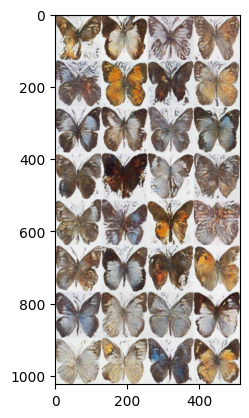

In [21]:
images = ddpm_pipeline(
    batch_size=32,
    generator=torch.manual_seed(config.seed)
).images

make_grid = make_image_grid(images, rows=8, cols=4)
plt.imshow(make_grid)